In [1]:
import sys
import os
sys.path.append(os.getcwd())

import torch
from gluonts.torch.modules.loss import NegativeLogLikelihood
from gluonts.torch.distributions.studentT import StudentTOutput
torch.serialization.add_safe_globals([NegativeLogLikelihood, StudentTOutput])

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.pandas import PandasDataset
from lag_llama.gluon.estimator import LagLlamaEstimator

C:\Users\Lenovo\lagllama_env\lib\site-packages\gluonts\json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


C:\Users\Lenovo\lagllama_env\lib\site-packages\gluonts\torch\util.py:205: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\python_variable_indexing.cpp:312.)
  return a[idx]
C:\Users\Lenovo\lagllama_env\lib\site-packages\gluonts\torch\util.py:205: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\python_variable_indexing.

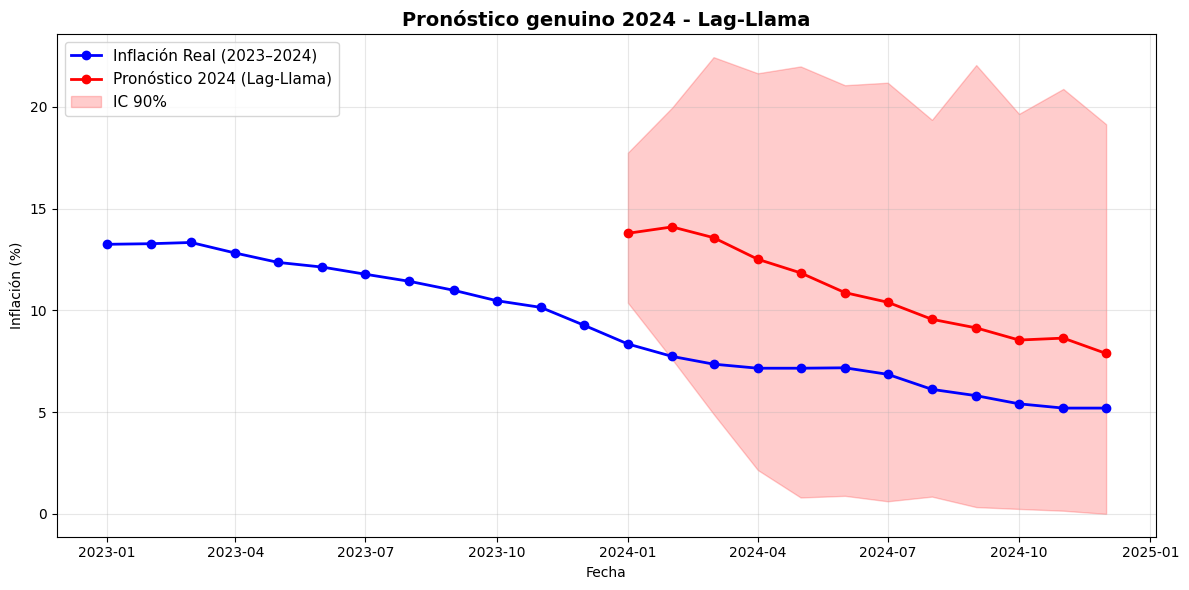

In [2]:
df = pd.read_excel(r"C:\Users\Lenovo\DATOS_IPC.xlsx", parse_dates=['Fecha'])
df = df.set_index('Fecha').asfreq('MS')
df['Inflacion'] = df['Inflacion'].astype('float32')

train_data = df[:'2023-12-31']
test_data = df['2024-01-01':]

prediction_length = 12  
context_length = 60    
num_samples = 300
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

ckpt = torch.load("lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
    ckpt_path="lag-llama.ckpt",
    prediction_length=prediction_length,
    context_length=context_length,
    device=torch.device(device),

  
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],

    nonnegative_pred_samples=True,
    batch_size=batch_size,
    num_parallel_samples=num_samples,

    rope_scaling={
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }
)

predictor = estimator.create_predictor(
    estimator.create_transformation(),
    estimator.create_lightning_module()
)


train_ds = PandasDataset(train_data, freq="M", target="Inflacion")


forecast_it, ts_it = make_evaluation_predictions(
    dataset=train_ds,
    predictor=predictor,
    num_samples=num_samples
)

forecasts = list(forecast_it)
forecast = forecasts[0]


forecast_index = pd.date_range(start="2024-01-01", periods=prediction_length, freq="MS")
forecast_df = pd.DataFrame({
    "Prediccion_Media": forecast.mean,
    "Percentil_5": forecast.quantile(0.05),
    "Percentil_95": forecast.quantile(0.95)
}, index=forecast_index)


comparison_df = forecast_df.copy()
if not test_data.empty:
    test_2024 = test_data['2024-01-01':'2024-12-31']
    comparison_df["Real"] = test_2024["Inflacion"].values


plt.figure(figsize=(12,6))


plt.plot(df.loc['2023-01-01':'2024-12-01'].index,
         df.loc['2023-01-01':'2024-12-01','Inflacion'],
         label="Inflación Real (2023–2024)", color="blue", linewidth=2, marker="o")


plt.plot(forecast_df.index, forecast_df['Prediccion_Media'],
         label="Pronóstico 2024 (Lag-Llama)", color="red", linewidth=2, marker="o")


plt.fill_between(forecast_df.index,
                 forecast_df['Percentil_5'],
                 forecast_df['Percentil_95'],
                 color="red", alpha=0.2, label="IC 90%")

plt.title("Pronóstico genuino 2024 - Lag-Llama", fontsize=14, fontweight="bold")
plt.xlabel("Fecha")
plt.ylabel("Inflación (%)")
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("pronostico_multistep_2024.png", dpi=300, bbox_inches="tight")
plt.show()

In [3]:
eval_df = comparison_df.dropna()

y_true = eval_df["Real"].values
y_pred = eval_df["Prediccion_Media"].values

# MAE
mae = np.mean(np.abs(y_true - y_pred))

# MSE
mse = np.mean((y_true - y_pred)**2)

# RMSE
rmse = np.sqrt(mse)

# MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  

print(f"MAPE: {mape:.2f}%")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


MAPE: 63.71%
MAE:  4.2781
MSE:  19.7869
RMSE: 4.4482
